In [1]:
import math
from math import *
#from geopy.geocoders import GoogleV3
import datetime
import time
import pytz
import ast
import codecs
import twitter
from pytz import datetime, timezone
import urllib
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import datetime, timezone
import googlemaps
%matplotlib inline
import pandas as pd
import sys

sys.path.append("/Users/waly/Documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares

#from pass_gallo import apikey
from pass_elgallo import apikey,apisecretkey,AccessToken,AccessTokenSecret
from pass_elgallo import google_key

In [ ]:
#map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,projection='mill',lon_0=0)
plt.figure(figsize=(12,6))
map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
#map = Basemap(llcrnrlon=-16, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='aqua')
#map.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#map.fillcontinents(color='coral',lake_color='aqua')
map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
map.drawcoastlines(linewidth=0.1, color="white")

# shade the night areas, with alpha transparency so the
# map shows through. Use current time in UTC.
date = datetime.utcnow()
CS=map.nightshade(date)

data = pd.DataFrame({
'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador']
})
# Add a marker per city of the data frame!
map.plot(data['lat'], data['lon'], linestyle='none', marker="o", markersize=8, 
         alpha=0.6, c="pink", markeredgecolor="black", markeredgewidth=1)

plt.title('Day/Night Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
plt.show()

In [ ]:
import googlemaps

In [ ]:
import googlemaps
from datetime import datetime

gmaps = googlemaps.Client(key=google_key)

# Geocoding an address
geocode_result = gmaps.geocode(['Almendralejo'])
#geocode_result = gmaps.timezone(location=(44,-1.0)) #latitude, longitude

In [ ]:
geocode_result

In [89]:
class Gallo:
    consumer_key=''
    consumer_secret=''
    access_token_key=''
    access_token_secret=''
    google_key=''
    
    def __init__(self,consumer_key_,
               consumer_secret_,
               access_token_key_,
               access_token_secret_,
                google_key_):
        self.consumer_key=consumer_key_
        self.consumer_secret=consumer_secret_
        self.access_token_key=access_token_key_
        self.access_token_secret=access_token_secret_
        self.google_key=google_key_
        
    def load_cities_formatted(self,fichero_ciudades_formateados):
        self.path_fichero_ciudades_formateado=fichero_ciudades_formateados
        cities=pd.read_csv(fichero_ciudades_formateados,
                           names=['Pais','Ciudad','Continente','localizacion','Time_Zone','offset_UTC'])
        self.ciudades=cities
        self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
    
    def load_cities_raw(self,fichero_ciudades_raw):
        gmaps = googlemaps.Client(key=self.google_key)
        self.ciudades=pd.read_csv(fichero_ciudades_raw,names=['Pais','Ciudad','Continente'])
        self.ciudades['localizacion']=self.ciudades.apply(lambda x :self.lat_y_lon((x['Ciudad']+','+x['Pais']),gmaps),axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x :self.time_zone(x['localizacion'],gmaps),axis=1)
        self.ciudades['offset_UTC']=self.ciudades.apply(lambda x:x['Time_Zone'][0],axis=1)
        self.ciudades['Time_Zone']=self.ciudades.apply(lambda x:x['Time_Zone'][1],axis=1)
        #self.ciudades['localizacion']=self.ciudades.apply(lambda x:ast.literal_eval(x['localizacion']),axis=1)
        
    def save_cities(self,path_fichero):
        self.ciudades.to_csv(path_fichero,header=False,index=False)

        
    def grados_a_radianes(self,grados_):
        return grados_/360*2*math.pi


    def radianes_a_grados(self,radianes_):
        return radianes_*360/2/math.pi


    def ecuacion_tiempo(self,dia_):
        valor=229.18*(-0.0334*math.sin(2*math.pi/365.24*dia_)+0.04184*math.sin(4*math.pi/365.24*dia_+3.5884))
        return valor


    def declinacion(self,n_):
        valor=-23.45*math.cos(self.grados_a_radianes(360/365*(n_+10)))
        return valor


    def angulo_solar(self,latitud_,declinacion_):
        a=math.sin(self.grados_a_radianes(-0.833))-math.sin(self.grados_a_radianes(latitud_))*math.sin(self.grados_a_radianes(declinacion_))
        b=math.cos(self.grados_a_radianes(declinacion_))*math.cos(self.grados_a_radianes(latitud_))
        cosenow=a/b
        return math.acos(cosenow)
    
    
    
    def lat_y_lon(self,x,gmaps):
        geocode_result=gmaps.geocode(x)
        return geocode_result[0]['geometry']['location']
    
    def time_zone(self,x,gmaps):
        timezone_result=gmaps.timezone(x)
        return timezone_result['rawOffset'],timezone_result['timeZoneName']
    
    
    def amanece_dia (self,latitud_,longitud_,dia_):
        
        timezone_utc=timezone('utc')
        dia_utc=timezone_utc.localize(dia_)
        orden_dia=int(dia_utc.strftime('%j'))
        declinacion_dia=self.declinacion(orden_dia)
        angulo=self.angulo_solar(latitud_,declinacion_dia)
        NHoras=self.radianes_a_grados(angulo)/7.5
        ajuste=self.ecuacion_tiempo(orden_dia)
        mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
        arco=datetime.timedelta(hours=NHoras/2)
        hora_amanecer_solar=mediodia_solar-arco
        hora_amanecer_utc=hora_amanecer_solar-datetime.timedelta(hours=longitud_/15)
        hora_amanecer_utc_ajustada=hora_amanecer_utc-datetime.timedelta(minutes=ajuste)
        hora_amanecer_utc_ajustada_localizada=timezone_utc.localize(hora_amanecer_utc_ajustada)
        hora_amanecer_utc_ajustada_localizada=hora_amanecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
        return hora_amanecer_utc_ajustada_localizada
        
    def anochece_dia (self,latitud_,longitud_,dia_):
        timezone_utc=timezone('utc')
        dia_utc=timezone_utc.localize(dia_)
        orden_dia=int(dia_.strftime('%j'))
        declinacion_dia=self.declinacion(orden_dia)
        angulo=self.angulo_solar(latitud_,declinacion_dia)
        NHoras=self.radianes_a_grados(angulo)/7.5
        ajuste=self.ecuacion_tiempo(orden_dia)
        mediodia_solar=datetime.datetime(dia_.year,dia_.month,dia_.day,12,0,0)
        arco=datetime.timedelta(hours=NHoras/2)
        hora_anochecer_solar=mediodia_solar+arco
        hora_anochecer_utc=hora_anochecer_solar-datetime.timedelta(hours=longitud_/15)
        hora_anochecer_utc_ajustada=hora_anochecer_utc-datetime.timedelta(minutes=ajuste)
        hora_anochecer_utc_ajustada_localizada=timezone_utc.localize(hora_anochecer_utc_ajustada)
        hora_anochecer_utc_ajustada_localizada=hora_anochecer_utc_ajustada_localizada.replace(year=dia_.year,month=dia_.month,day=dia_.day)
        return hora_anochecer_utc_ajustada_localizada
        
    #def annade_amanece_anochece(self):
    #    hora_comparativa='%H:%M:%S %m %d'
    #    ahora=datetime.datetime.utcnow()
    #    for i in self.ciudades.index:
    #    
    #    self.ciudades['amanece']=self.ciudades.apply(lambda x:self.amanece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                 strftime(hora_comparativa),axis=1)
    #    self.ciudades['anochece']=self.ciudades.apply(lambda x:self.anochece_dia(x['localizacion']['lat'],
    #                                                                      x['localizacion']['lng'],ahora).
    #                                                  strftime(hora_comparativa),axis=1)
     
    def annade_amanece_anochece(self):
        hora_comparativa='%H:%M:%S %m %d'
        un_dia=datetime.timedelta(days=1)
        ahora=datetime.datetime.utcnow()
        timezone_utc=timezone('utc')
        ahora_utc=timezone_utc.localize(ahora)
        serie_amanece=pd.Series()
        serie_anochece=pd.Series()
        for i in self.ciudades.index:
            hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora)
            if hora<ahora_utc:
                hora=self.amanece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
            serie_amanece.loc[i]=hora.strftime(hora_comparativa)
            self.ciudades['amanece']=serie_amanece
        for i in self.ciudades.index:
            hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora)
            if hora<ahora_utc:
                hora=self.anochece_dia(self.ciudades.loc[i]['localizacion']['lat'],
                                  self.ciudades.loc[i]['localizacion']['lng'],ahora+un_dia)
            serie_anochece.loc[i]=hora.strftime(hora_comparativa)
            self.ciudades['anochece']=serie_anochece
        return
    
    
    def mapa(self,path,lat,long,color):
        plt.figure(figsize=(12,6))
        map = Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80,lon_0=100)
        map.drawcoastlines()
        map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
        map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
        map.drawmapboundary(fill_color='aqua')
        map.fillcontinents(color='coral', alpha=0.7, lake_color='grey')
        map.drawcoastlines(linewidth=0.1, color="white")
        date = datetime.datetime.utcnow()
        CS=map.nightshade(date)
        map.plot(long,lat, linestyle='none', marker="o", markersize=24,
                 alpha=0.6, c=color, markeredgecolor="black", markeredgewidth=1)
        plt.title('Day/Night Map for {} (UTC)'.format(date.strftime("%d %b %Y %H:%M:%S")))
        plt.savefig(path)
        plt.show()
        return path
    
    
    def send_tweet(self,ciudad,pais,continente,hora_local,hora_utc,nueva_hora,path,accion):
        CR='\n'
        hora='%H:%M:%S'
        textos={'amanece':('Good morning','sun rising'),'anochece':('Good evening','sunset')}
        api=twitter.Api(self.consumer_key,
               self.consumer_secret,
               self.access_token_key,
               self.access_token_secret,
               sleep_on_rate_limit=True)
        
        Text1=('{}, {} at {}, {} ({})'.format(textos[accion][0],textos[accion][1],'#'+ciudad.replace(' ',''),
                                                                  '#'+pais,'#'+continente))
        Text2=('{0:<10} {1:<15}'.format('UTC time',hora_utc.strftime(hora)))
        Text3=('{0:<10} {1:<15}'.format('Local time',hora_local.strftime(hora)))
        Text4=('{0:<10} {1} at {2:<15}'.format('Tomorrow',textos[accion][1],nueva_hora.strftime(hora)))
        Text5='#roostercrow'
        Text6='#elgallodelaaurora'
        texto=Text1+CR+Text2+CR+Text3+CR+Text4+CR+Text5+CR+Text6
        print (texto)
        estado = api.PostUpdate(texto,media=path)
        return                                                
    
    def run(self):
        hora_comparativa='%H:%M:%S %m %d'
        un_dia=datetime.timedelta(days=1)
        while True:
            ahora=datetime.datetime.utcnow()
            ahora_texto=ahora.strftime(hora_comparativa)
            #ahora_texto="02:08:36 02 17"
            lista_ciudades=self.ciudades[self.ciudades['amanece']==ahora_texto]
            
            if lista_ciudades.shape[0]!=0:
                #print (lista_ciudades.iloc[0])
                nueva_hora=self.amanece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                            lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
                self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&
                                  (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),
                                  ['amanece']]=nueva_hora.strftime(hora_comparativa)
                #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & 
                                    #(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
                ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                          lista_ciudades.iloc[0]['localizacion']['lng'],'yellow')
                self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                                lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'amanece')
            
            lista_ciudades=self.ciudades[self.ciudades['anochece']==ahora_texto]
            if lista_ciudades.shape[0]!=0:
                #print (lista_ciudades.iloc[0])
                nueva_hora=self.anochece_dia(lista_ciudades.iloc[0]['localizacion']['lat'],
                                            lista_ciudades.iloc[0]['localizacion']['lng'],ahora+un_dia)
                self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais'])&(self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad']),['anochece']]=nueva_hora.strftime(hora_comparativa)
                #print (self.ciudades.loc[(self.ciudades['Pais']==lista_ciudades.iloc[0]['Pais']) & (self.ciudades['Ciudad']==lista_ciudades.iloc[0]['Ciudad'])])
                ahora_local=ahora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                nueva_hora_local=nueva_hora+datetime.timedelta(hours=lista_ciudades.iloc[0]['offset_UTC']/3600)
                path=self.mapa('mapa.png',lista_ciudades.iloc[0]['localizacion']['lat'],
                          lista_ciudades.iloc[0]['localizacion']['lng'],'blue')
                self.send_tweet(lista_ciudades.iloc[0]['Ciudad'],lista_ciudades.iloc[0]['Pais'],
                                lista_ciudades.iloc[0]['Continente'],ahora_local,ahora,nueva_hora_local,path,'anochece')

In [90]:
fichero='cities.csv'
fichero_format='cities_formatted.csv'
gallo=Gallo(apikey,apisecretkey,AccessToken,AccessTokenSecret,google_key)
gallo.load_cities_formatted(fichero_format)


In [ ]:
ahora_utc=datetime.datetime.utcnow()
ahora=datetime.datetime.now()
nueva_hora=ahora+un_dia
path='prueba.png'
accion='amanece'

In [91]:
gallo.annade_amanece_anochece()

In [ ]:
gallo.send_tweet('Madrid','Spain','Europa',hora,ahora_utc,nueva_hora,path,accion)

/Users/waly/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


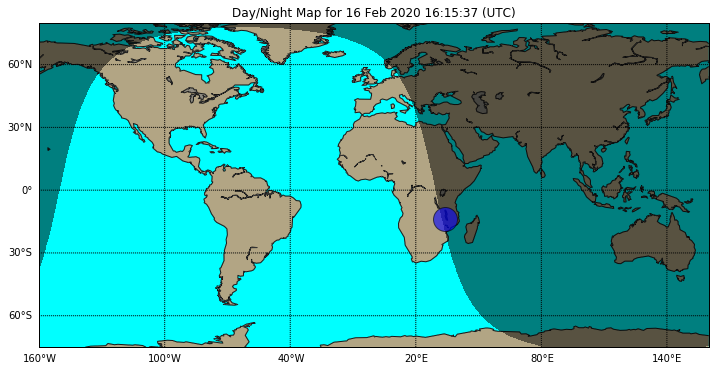

Good evening, sunset at #Lilongwe, #Malawi (#Africa)
UTC time   16:15:37       
Local time 18:15:37       
Tomorrow   sunset at 18:15:11       
#roostercrow
#elgallodelaaurora


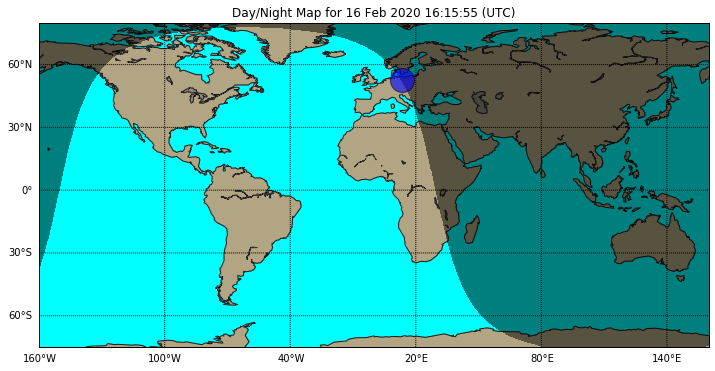

Good evening, sunset at #Berlin, #Germany (#Europe)
UTC time   16:15:55       
Local time 17:15:55       
Tomorrow   sunset at 17:17:46       
#roostercrow
#elgallodelaaurora


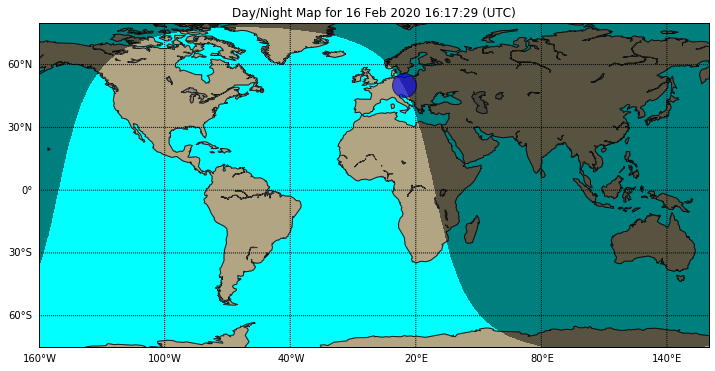

Good evening, sunset at #Prague, #Czech Republic (#Europe)
UTC time   16:17:29       
Local time 17:17:29       
Tomorrow   sunset at 17:19:10       
#roostercrow
#elgallodelaaurora


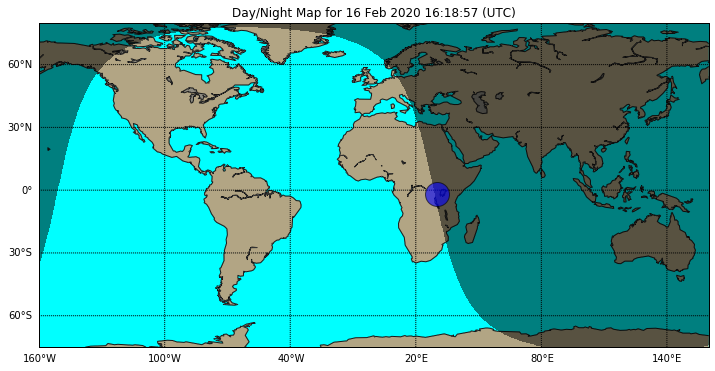

Good evening, sunset at #Kigali, #Rwanda (#Africa)
UTC time   16:18:57       
Local time 18:18:57       
Tomorrow   sunset at 18:18:50       
#roostercrow
#elgallodelaaurora


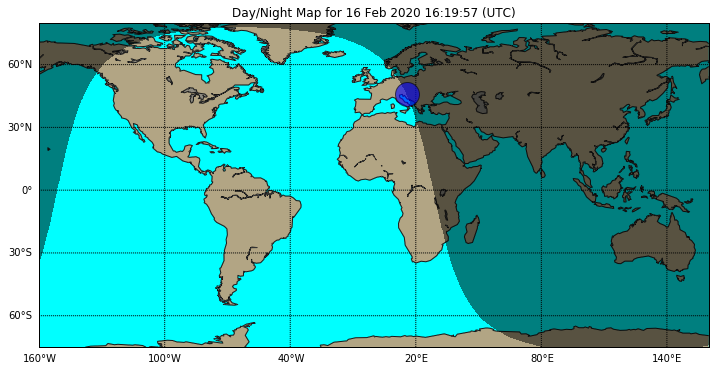

Good evening, sunset at #Zagreb, #Croatia (#Europe)
UTC time   16:19:57       
Local time 17:19:57       
Tomorrow   sunset at 17:21:22       
#roostercrow
#elgallodelaaurora


In [ ]:
gallo.run()

In [ ]:
hora=datetime.datetime.strptime(gallo.ciudades.loc[0]['amanece'],'%H:%M:%S %m %d').replace(year=2020)

In [ ]:
horas=gallo.ciudades['anochece'].apply(lambda x:datetime.datetime.strptime(x,'%H:%M:%S %m %d').replace(year=2020))

In [ ]:
ahora=datetime.datetime.utcnow()

In [ ]:
(horas>ahora).sum()